# PCA for Facial Image Recognition

## Introduction

In this lesson, you'll get to explore an exciting application of PCA: PCA can be used for preprocessing facial image recognition data!

## Objectives

You will be able to:

- Use PCA to discover the principal components of image data
- Use the principal components of a dataset as features in a machine learning model 

## Load the data

First, let's load the dataset.

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

In [2]:
data = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\SRIRASUBRAMANIAN\scikit_learn_data


## Preview the images in the dataset

Next, we'll take a quick preview of the images within the dataset.

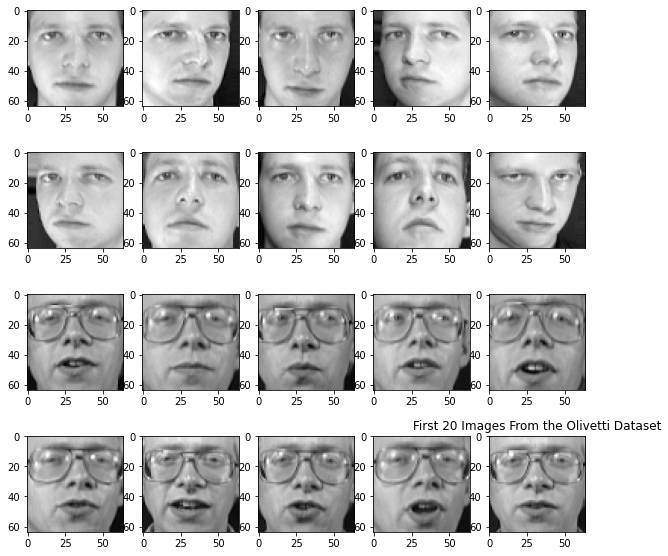

In [3]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10,10))
for n in range(20):
    i = n //5
    j = n%5
    ax = axes[i][j]
    ax.imshow(data.images[n], cmap=plt.cm.gray)
plt.title('First 20 Images From the Olivetti Dataset');

## Train a baseline classifier

You'll soon take a look at the performance gains by using PCA as a preprocessing technique. To compare the performance, here's an out-of-the-box classifier's performance.

In [4]:
from sklearn import svm
from sklearn.model_selection import train_test_split

In [5]:
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [6]:
clf = svm.SVC(C=5, gamma=0.05)
%timeit clf.fit(X_train, y_train)

453 ms ± 67.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_acc, test_acc))

Training Accuracy: 1.0	Testing Accuracy: 0.74


## Grid search on the baseline classifier

To produce a more robust baseline to compare against, let's see how much performance you can squeeze by conducting a grid search to find optimal hyperparameters for the model. It's also worth timing the duration of training such a model, as PCA will drastically decrease training time and it's interesting to observe this performance gain.

> **Warning**: ⏰ It's not recommended to run the cell below. (Doing so is apt to take well over an hour, depending on the particular specs of your machine.)

In [8]:
# ⏰ This cell may take over an hour to run!
import numpy as np
from sklearn.model_selection import GridSearchCV

clf = svm.SVC()
param_grid = {'C' : np.linspace(0.1, 10, num=11),
             'gamma' : np.linspace(10**-3, 5, num=11)}

grid_search = GridSearchCV(clf, param_grid, cv=5)

%timeit grid_search.fit(X_train, y_train)

10min 17s ± 6.79 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
grid_search.best_estimator_.score(X_test, y_test)

0.91

## Preprocessing with PCA

Now it's time to perform some dimensionality reduction with PCA! To start, you can simply pick an arbitrary number of components. Later, you can compare the performance of a varying number of components.

Note that to avoid information leakage from the test set, PCA should only be fit on the training data.

In [8]:
from sklearn.decomposition import PCA

In [9]:
X[0].shape

(4096,)

In [10]:
pca = PCA(n_components=100, whiten=True)
X_pca_train = pca.fit_transform(X_train)
X_pca_train.shape

(300, 100)

In [11]:
X_pca_train[0].shape

(100,)

## Explore the explained variance captured by principal components

How much of the total data was captured in these compressed representations? Take a quick look at a plot of the explained variance to explore this.

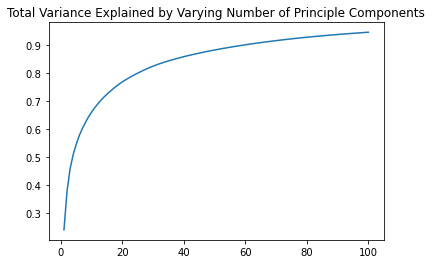

In [12]:
plt.plot(range(1,101), pca.explained_variance_ratio_.cumsum())
plt.title('Total Variance Explained by Varying Number of Principle Components');

## Train a classifier on the compressed dataset

Now it's time to compare the performance of a classifier trained on the compressed dataset.

In [13]:
X_pca_test = pca.transform(X_test)
clf = svm.SVC()
%timeit clf.fit(X_pca_train, y_train)

18.7 ms ± 3.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
train_pca_acc = clf.score(X_pca_train, y_train)
test_pca_acc = clf.score(X_pca_test, y_test)
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_pca_acc, test_pca_acc))

Training Accuracy: 1.0	Testing Accuracy: 0.93


## Grid search for appropriate parameters

Going further, you can also refine the model using grid search.

In [18]:
# ⏰ This cell may take several minutes to run
clf = svm.SVC()

param_grid = {'C' : np.linspace(0.1, 10, num=11),
             'gamma' : np.linspace(10**-3, 5, num=11)}

grid_search = GridSearchCV(clf, param_grid, cv=5)

%timeit grid_search.fit(X_pca_train, y_train)

/Users/matthew.mitchell/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/matthew.mitchell/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


16.8 s ± 25.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
grid_search.best_params_

{'C': 10.0, 'gamma': 0.001}

In [20]:
grid_search.best_estimator_.score(X_pca_test, y_test)

0.89

## Visualize some of the features captured by PCA

While this model may have lost some accuracy, it is clearly much faster to train. Let's take a moment to visualize some of the information captured by PCA. Specifically, you'll take a look at two perspectives. First, you'll take a look at visualizing the feature means. Second, you'll get to visualize the compressed encodings of the dataset.

### Visualize feature means

While it is a very simple mathematical model, just observing the mean values of the features produces quite an informative picture:

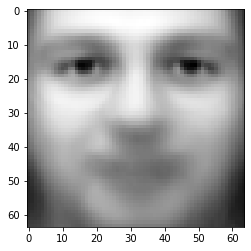

In [15]:
plt.imshow(X.mean(axis=0).reshape(data.images[0].shape), cmap=plt.cm.gray)

### Visualize compressed representations

Visualizing the components from PCA is slightly tricky, as they have new dimensions which may not correspond accurately to the 64x64 size of the original images. Fortunately, scikit-learn provides a useful `.inverse_transformation()` method to PCA allowing you to reproject the compressed dataset back to the original size. This allows you to observe what features are retrieved and encapsulated within the principal components.

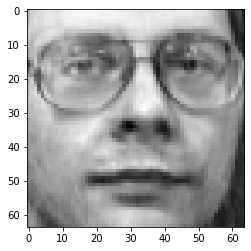

In [17]:
fig, axes
plt.imshow(pca.inverse_transform(X_pca_train[0]).reshape(64,64), cmap=plt.cm.gray)

To make this even more interesting, take a look at some of the varied levels of detail based on varying number of principle components:

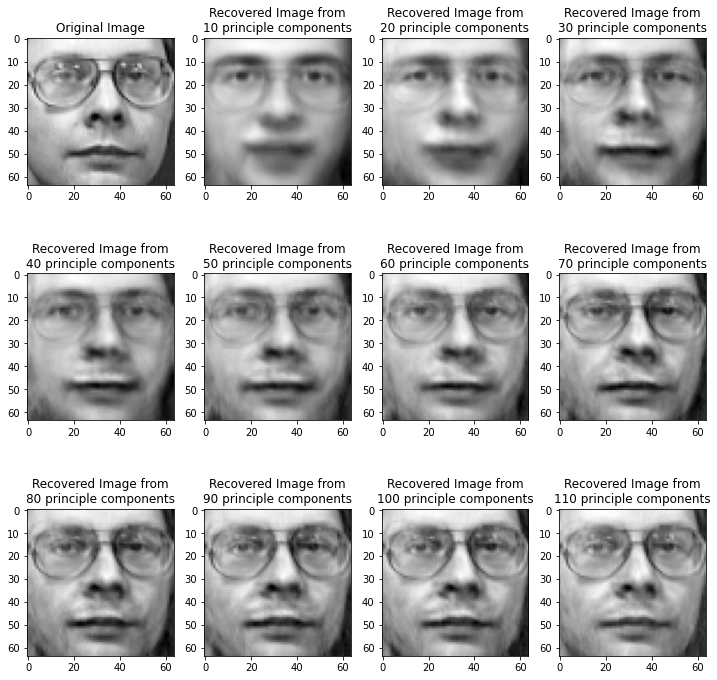

In [18]:
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(10,10))
ax = axes[0][0]
ax.set_title('Original Image')
ax.imshow(X_train[0].reshape(64,64), cmap=plt.cm.gray)
for n in range(1,12):
    i = n //4
    j = n%4
    ax = axes[i][j]
    ax.set_title('Re')
    n_feats = n*10
    pca = PCA(n_components=n_feats)
    pca.fit(X_train)
    compressed = pca.transform(X_train)
    ax.set_title('Recovered Image from\n{} principle components'.format(n_feats))
    ax.imshow(pca.inverse_transform(compressed[0]).reshape(64,64), cmap=plt.cm.gray)
plt.tight_layout()

## Summary

Awesome! In this lesson, you saw how you can use PCA to reduce the dimensionality of a complex dataset. In the next lab, you'll get a chance to put these same procedures to the test in working with the MNIST dataset.